# Inference of DeepSpot2Cell on H&E Images

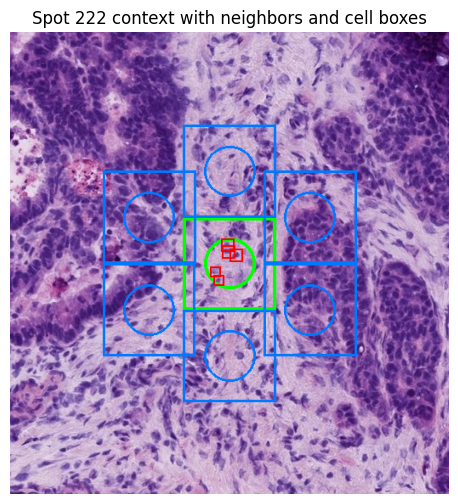

In [ ]:
from pathlib import Path
import json
import torch

from deepspot2cell import DeepSpot2Cell
from deepspot2cell.utils import (
    predict_spot2cell_from_image_paths,
    get_morphology_model_and_preprocess,
 )
from notebook_utils import get_example_spot_context

MODEL_CHECKPOINT = Path("path/to/deepspot2cell.ckpt")
MORPHOLOGY_MODEL_PATH = Path("path/to/phikonv2/model")
MORPHOLOGY_MODEL_NAME = "phikonv2"
GENE_NAMES_PATH = None  # optional
OUTPUT_SIZE = 1000  # number of genes in the trained model

cell_image_paths, spot_image_path, neighbor_image_paths = get_example_spot_context()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

gene_names = None
if GENE_NAMES_PATH:
    gene_path = Path(GENE_NAMES_PATH)
    with gene_path.open("r", encoding="utf-8") as fh:
        gene_names = json.load(fh)

morphology_model, preprocess, input_size = get_morphology_model_and_preprocess(
    MORPHOLOGY_MODEL_NAME,
    device=device,
    model_path=str(MORPHOLOGY_MODEL_PATH),
)
morphology_model = morphology_model.to(device)
morphology_model.eval()

deepspot_model = DeepSpot2Cell(input_size=input_size, output_size=OUTPUT_SIZE)
checkpoint = torch.load(MODEL_CHECKPOINT, map_location=device)
state_dict = checkpoint.get("state_dict") if isinstance(checkpoint, dict) and "state_dict" in checkpoint else checkpoint
deepspot_model.load_state_dict(state_dict)
deepspot_model = deepspot_model.to(device)
deepspot_model.eval()

main_cell_path = cell_image_paths[0]
cell_predictions = predict_spot2cell_from_image_paths(
    cell_image_path=str(main_cell_path),
    spot_image_path=str(spot_image_path),
    neighbor_image_paths=[str(p) for p in neighbor_image_paths],
    deepspot2cell_model=deepspot_model,
    morphology_model=morphology_model,
    preprocess=preprocess,
    device=device,
    gene_names=gene_names,
)

print(f"Single-cell prediction for spot {spot_image_path.stem} (cell tile: {main_cell_path.name})")
for gene, value in list(sorted(cell_predictions.items(), key=lambda item: item[1], reverse=True))[:10]:
    print(f"{gene}: {value:.4f}")

In [ ]:
from notebook_utils import predict_spot_expression_from_image_paths

spot_predictions = predict_spot_expression_from_image_paths(
    cell_image_paths=cell_image_paths,
    spot_image_path=spot_image_path,
    neighbor_image_paths=neighbor_image_paths,
    deepspot2cell_model=deepspot_model,
    morphology_model=morphology_model,
    preprocess=preprocess,
    device=device,
    gene_names=gene_names,
 )

print(f"\nSpot-level prediction aggregating {len(cell_image_paths)} cells")
for gene, value in list(sorted(spot_predictions.items(), key=lambda item: item[1], reverse=True))[:10]:
    print(f"{gene}: {value:.4f}")